In [53]:
import numpy as np 
import random
import torch 
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [54]:
def data_creation(n,len,value_low=0,value_high=1):
    nums =  np.zeros((n,len,1))                                                       
    values = np.zeros((n,len,1))                                                      
    sums = np.ones((n,1))                                                             
                                                                                      
    for i in range(n):                                                                
        seq_len = np.random.randint(2,len)                                            
        num_values = np.random.uniform(0,1,size=(seq_len))                            
        num_values = np.pad(num_values,(0,len-seq_len))
        #print(nums.shape,num_values.shape)
        nums[i] = num_values.reshape(-1,1)

        ones = random.sample(range(seq_len), 2)
        bin_str = [0] * seq_len
        bin_str[ones[0]] = 1
        bin_str[ones[1]] = 1
        bin_mask=bin_str

        # bin_mask = generate_random_binary_string(seq_len)
        bin_mask = np.pad(bin_mask,(0,len-seq_len))
        values[i]=bin_mask.reshape(-1,1)
        sums[i,0] = np.dot(bin_mask,nums[i])
    return  np.append(nums,values,axis=2),sums

In [55]:
train_data,y_train = data_creation(5000,9,0,1)  #here 9 is max seq length
print(train_data.shape)

(5000, 9, 2)


In [56]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y

In [57]:
import torch
import torch.nn as nn
class elmon_(nn.Module):
    def __init__(self,n_samples=100, input_size=2, hidden_size=64,num_classes=1):
        super(elmon_, self).__init__()
        self.weight_x = nn.Parameter(torch.randn(input_size, hidden_size).double())
        self.weight_h = nn.Parameter(torch.randn(hidden_size, hidden_size).double())
        self.bias = nn.Parameter(torch.randn(hidden_size,))
        self.weight_a =  nn.Parameter(torch.randn(hidden_size,num_classes).double())
        self.ba =  nn.Parameter(torch.randn(num_classes,).double())
       
    
        
    def forward(self, input):
        seq_len = input.shape[1]
        n = input.shape[0]        
      
        hidden_size = self.weight_h.shape[0]
        h = torch.zeros((n,hidden_size)).double()
        
        for i in range(seq_len):
            h = torch.tanh(self.bias  + (input[:,i,:]).mm(self.weight_x) + h.mm(self.weight_h))
        y =  self.ba + h.mm(self.weight_a) 
        return y
    
    def loss_nn(self,predict,y):
        return nn.MSELoss(predict,y)

In [58]:
#traing the model
model = elmon_()
test_data,y_test = data_creation(1000,9,0,1)
test_data = np.array(test_data)
train_data = np.array(train_data)
y_test = np.array(y_test)
y_train = np.array(y_train)
loss_list = []
d_train = CustomDataset(train_data,y_train)
d_test = CustomDataset(test_data,y_test)
dl_train = DataLoader(d_train, batch_size=100, num_workers=1, shuffle=True)
dl_test = DataLoader(d_test, batch_size=100, num_workers=1, shuffle=False)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
for epoch in range(10):
    for i, (x_input, y_input) in enumerate(dl_train):
        outs = model(x_input)
        loss = criterion(outs, y_input)
        optimizer.zero_grad()
        loss_list.append(loss)
        loss.backward()
        optimizer.step()

In [59]:
import torch
import torch.nn as nn
class LSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=64,num_classes=1):
        super(LSTM, self).__init__()
        self.weight_x = nn.Parameter(torch.randn(input_size, 4*hidden_size).double())
        self.weight_h = nn.Parameter(torch.randn(hidden_size, 4*hidden_size).double())
        self.bias = nn.Parameter(torch.randn(4*hidden_size,))
        self.weight_a =  nn.Parameter(torch.randn(hidden_size,num_classes).double())
        self.ba =  nn.Parameter(torch.randn(num_classes,).double())
        
    
        
    def forward(self, input):
        seq_len = input.shape[1]
        n = input.shape[0]        
            
        hidden_size = self.weight_h.shape[0]
        h = torch.zeros((n,hidden_size)).double()
        c = torch.zeros((n,hidden_size)).double()
        
        for i in range(seq_len):
            a = torch.tanh(self.bias  + (input[:,i,:]).mm(self.weight_x)+ h.mm(self.weight_h))
            i = torch.sigmoid(a[:, 0:hidden_size])
            f = torch.sigmoid(a[:, hidden_size:2*hidden_size])
            o = torch.sigmoid(a[:, 2*hidden_size:3*hidden_size])
            g = torch.sigmoid(a[:, 3*hidden_size:4*hidden_size])
            c = f*c + i*g
            h = o*torch.tanh(c)
            #h = np.tanh(self.bias + np.dot(self.weight_x,input[:,i,:]) + np.dot(h,self.weight_h))
        y = self.ba + h.mm(self.weight_a) 
        return y
    
    def loss_nn(self,predict,y):
        return nn.MSELoss(predict,y)

In [60]:
model = LSTM()
test_data,y_test = data_creation(1000,9,0,1)
test_data = np.array(test_data)
train_data = np.array(train_data)
y_test = np.array(y_test)
y_train = np.array(y_train)
d_train = CustomDataset(train_data,y_train)
d_test = CustomDataset(test_data,y_test)
dl_train = DataLoader(d_train, batch_size=100, num_workers=1, shuffle=True)
dl_test = DataLoader(d_test, batch_size=100, num_workers=1, shuffle=False)
optimizer = optim.Adam(model.parameters(), lr=0.001)
LSTMloss_list = []
criterion = nn.MSELoss()
for epoch in range(10):
    for i, (inputs, labels) in enumerate(dl_train):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        LSTMloss_list.append(loss)
        loss.backward()
        optimizer.step()





In [61]:
loss_vec_elmon = [float(i) for i in loss_list]
loss_vec_lstm = [float(i) for i in LSTMloss_list]

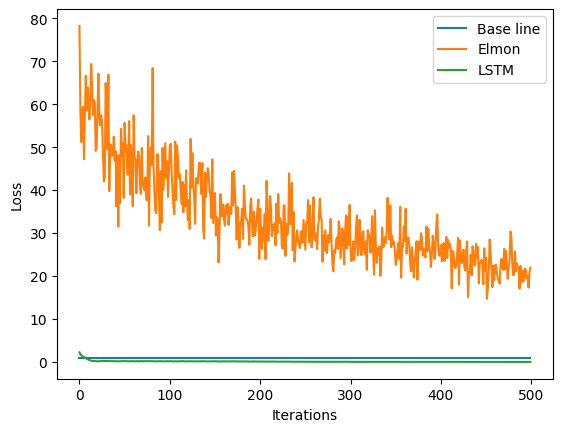

In [62]:
import matplotlib.pyplot as plt

pointer = [j for j in range(500)]
base_line = [1 for j in range(500)]

plt.plot(pointer,base_line,label='Base line')
plt.plot(pointer,loss_vec_elmon,label='Elmon')
plt.plot(pointer,loss_vec_lstm,label='LSTM')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()